In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import setup_logging, style
from nbodykit import use_mpi
from nbodykit.io.gadget import Gadget1File
from nbodykit.lab import ArrayMesh
from nbodykit.source.catalog import Gadget1Catalog

import numpy as np
import math

import time

from scipy import integrate
from scipy import interpolate

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [3]:
redshift = 0.0
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')

In [4]:
print(cosmo)

{'output': 'vTk dTk mPk', 'extra metric transfer functions': 'y', 'h': 0.6774, 'N_ur': 2.0328, 'gauge': 'synchronous', 'n_s': 0.9667, 'ln10^{10}A_s': 3.064, 'k_pivot': 0.05, 'tau_reio': 0.066, 'T_cmb': 2.7255, 'Omega_cdm': 0.2589, 'Omega_b': 0.0486, 'Omega_k': 0.0, 'N_ncdm': 1, 'm_ncdm': [0.06], 'P_k_max_h/Mpc': 10.0, 'z_max_pk': 100.0}


In [5]:
cosmo.Omega0_m

0.30890374144332966

In [10]:
cosmo_new = cosmo.match(sigma8=0.846687)

In [11]:
print(cosmo_new)

{'output': 'vTk dTk mPk', 'extra metric transfer functions': 'y', 'h': 0.6774, 'N_ur': 2.0328, 'gauge': 'synchronous', 'n_s': 0.9667, 'k_pivot': 0.05, 'tau_reio': 0.066, 'T_cmb': 2.7255, 'Omega_cdm': 0.2589, 'Omega_b': 0.0486, 'Omega_k': 0.0, 'N_ncdm': 1, 'P_k_max_h/Mpc': 10.0, 'z_max_pk': 100.0, 'A_s': 2.3064514006376223e-09, 'm_ncdm': [0.06]}


In [20]:
cosmo.ln_1e10_A_s = cosmo.ln_1e10_A_s + np.log(0.928598)

ValueError: the Cosmology object is immutable; use clone() or match() to update parameters

In [22]:
cosmo_new = cosmo.clone()

In [24]:
cosmo_new.ln_1e10_A_s = cosmo_new.ln_1e10_A_s + np.log(0.928598)

ValueError: the Cosmology object is immutable; use clone() or match() to update parameters

In [16]:
cosmo['ln10^{10}A_s']

TypeError: 'Cosmology' object is not subscriptable

In [4]:
#masaki params
#Omega_m = 0.3156
#Omega_L = 0.6844
#lambdaz = 0.01
#factor = 1.

#planck2015 params
Omega_m = 0.3089
Omega_L = 0.6911
lambdaz = 0.1
factor = 1.

def Hubble(a):
    matter = Omega_m/a**3
    Lambda = Omega_L
    return np.sqrt(matter+Lambda)

def growth_int(a):
    return 1./(a*Hubble(a))**3

def growth_D(a):
    factor = 5*Omega_m*Hubble(a)/2
    return factor*integrate.quad(growth_int, 0, a)[0]

def rel_D(z):
    a = 1/(1+z)
    return growth_D(a)/growth_D(1)

In [5]:
rel_D(49)

0.025501351477406977

In [6]:
pow = {}

seedlist = []
for i in range(1991,2007+1):
    seedlist.append(str(i))

for seed in seedlist:
    for kind in ['iso']:
            pow[seed+'_'+kind+'_p0'] = np.loadtxt(f'/mnt/sdceph/users/yinli/csit/planck2015/1000/{seed}/{kind}/power/ic_p0.dat')
            pow[seed+'_'+kind+'_p2'] = np.loadtxt(f'/mnt/sdceph/users/yinli/csit/planck2015/1000/{seed}/{kind}/power/ic_p2.dat')

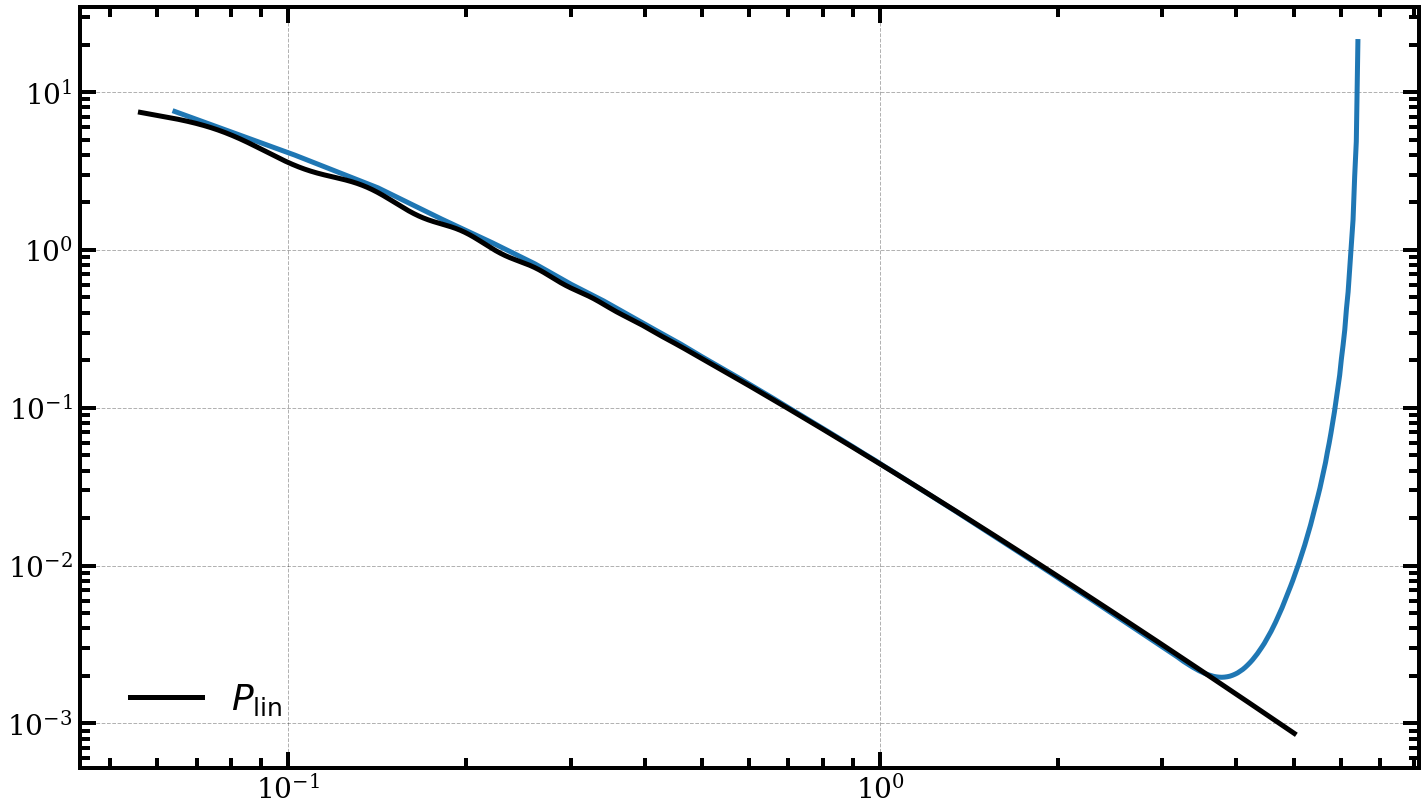

In [13]:
#plt.plot(pow['treepm2048_z0_mmp_p0'][0], pow['treepm2048_z0_mmp_p0'][1], label="mmp")
#plt.plot(pow['pm512_iso_p0'][0], pow['pm512_iso_p0'][1], label="PM512 iso")
#for seed in seedlist:
#    plt.plot(pow[seed+'_z0_iso_p0'][0], pow[seed+'_z0_iso_p0'][1])
#plt.plot(pow['1994_z0_iso_p0'][0], pow['1994_z0_iso_p0'][1])
plt.plot(pow['1991_iso_p0'][0], pow['1991_iso_p0'][1])
#plt.plot(pow['2007_iso_p0'][0], pow['2007_iso_p0'][1])
k = numpy.logspace(-1.25, 0.7, 10000)
plt.loglog(k, Plin(k)*rel_D(49)*rel_D(49), c='k', label=r'$P_\mathrm{lin}$')
#plt.plot(pow['1992_treepm2048_z0_iso_p0'][0], pow['1992_treepm2048_z0_iso_p0'][1], label="1992")
#plt.plot(pow['treepm2048_z1_iso_p0'][0], pow['treepm2048_z1_iso_p0'][1], label="z=1")
#plt.plot(pow['treepm2048_z2_iso_p0'][0], pow['treepm2048_z2_iso_p0'][1], label="z=2")
#plt.plot(pow['treepm2048_z3_iso_p0'][0], pow['treepm2048_z3_iso_p0'][1], label="z=3")
#plt.plot(pow['treepm2048_z7_iso_p0'][0], pow['treepm2048_z7_iso_p0'][1], label="z=7")


plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=18)
plt.xscale('log')
plt.yscale('log')

In [ ]:
Gk = {}

for force in ['treepm2048']:
    for seed in seedlist:
        for redshift in ['0']:
            Gk[seed+'_'+force+'_z'+redshift] = np.array([pow[seed+'_'+force+'_z'+redshift+'_iso_p0'][0], (pow[seed+'_'+force+'_z'+redshift+'_mmp_p2'][1] - pow[seed+'_'+force+'_z'+redshift+'_ppm_p2'][1])/(2*lambdaz*pow[seed+'_'+force+'_z'+redshift+'_iso_p0'][1]*rel_D(int(redshift)))])
            np.savetxt(f'/home/yinli/csit/analysis/power/planck2015/1000/{seed}/Gk_z{redshift}_{force}_{seed}.dat', Gk[seed+'_'+force+'_z'+redshift])

In [6]:
Gk = {}

for force in ['treepm256','treepm512','pm256','pm512','pm1024','pm2048','pm4096']:
    Gk[force] = np.array([pow[force+'_iso_p0'][0], (pow[force+'_mmp_p2'][1] - pow[force+'_ppm_p2'][1])/(2*lambdaz*pow[force+'_iso_p0'][1]*rel_D(0))])
    np.savetxt(f'/home/yinli/csit/analysis/response/planck2015/250/Gk_z0_{force}.dat', Gk[force])

In [ ]:
for seed in seedlist:
    plt.plot(Gk[seed+'_treepm2048_z0'][0], Gk[seed+'_treepm2048_z0'][1], label=seed)

#plt.plot(Gk['treepm2048_z1'][0], Gk['treepm2048_z1'][1], label="z=1")
#plt.plot(Gk['treepm2048_z2'][0], Gk['treepm2048_z2'][1], label="z=2")
#plt.plot(Gk['treepm2048_z3'][0], Gk['treepm2048_z3'][1], label="z=3")
#plt.plot(Gk['treepm2048_z7'][0], Gk['treepm2048_z7'][1], label="z=7")


#plt.plot(Gk['pm4096'][0], Gk['pm4096'][1], label="PM4096")
#plt.plot(Gk['pm256'][0], Gk['pm256'][1], label="PM256")
#plt.plot(Gk['pm1024'][0], Gk['pm1024'][1], label="PM1024")


plt.hlines([8./7.], Gk['1991_treepm2048_z0'][0,0], Gk['1991_treepm2048_z0'][0,-1], "blue", linestyles='dashed')     # hlines

plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=18)
#plt.xlim(0.015, 20)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$G(k)$ ")
plt.xscale('log')
#plt.savefig('/home/yinli/csit/analysis/power/planck2015/1000/Gk_1992.pdf')

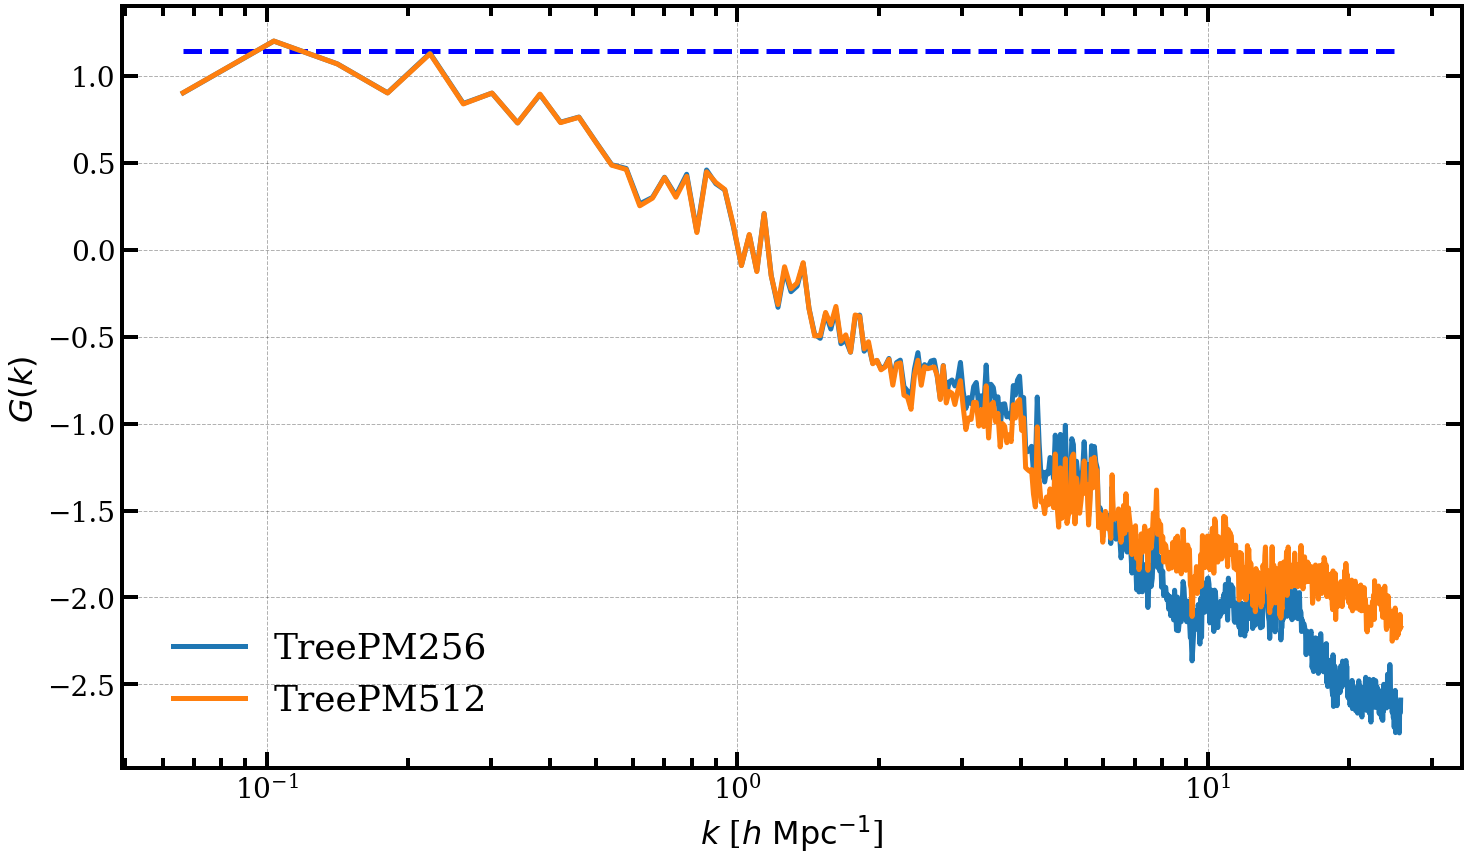

In [22]:
plt.plot(Gk['treepm256'][0], Gk['treepm256'][1], label="TreePM256")
plt.plot(Gk['treepm512'][0], Gk['treepm512'][1], label="TreePM512")
#plt.plot(Gk['pm4096'][0], Gk['pm4096'][1], label="PM4096")
#plt.plot(Gk['pm256'][0], Gk['pm256'][1], label="PM256")
#plt.plot(Gk['pm1024'][0], Gk['pm1024'][1], label="PM1024")


plt.hlines([8./7.], Gk['treepm256'][0,0], Gk['treepm256'][0,-1], "blue", linestyles='dashed')     # hlines

plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=18)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$G(k)$ ")
plt.xscale('log')
plt.savefig('/home/yinli/csit/analysis/response/planck2015/250/Gk_compare_treepm.pdf')

In [8]:
np.log10(Gk['treepm256'][0,0])

-1.1778663900572262

In [9]:
np.log10(Gk['treepm256'][0,-1])

1.4099332448452262

In [16]:
n_bin = 13
logpow = {}
logmink = -1.1
logmaxk = 1.4

logpow['k'] = np.logspace(logmink, logmaxk, n_bin)

for force in ['treepm256', 'treepm512', 'pm256', 'pm512','pm1024','pm2048','pm4096']:
    for kind in ['iso', 'mmp', 'ppm']:
        logpow[force+'_'+kind] = np.zeros(n_bin)
        
for i in range(n_bin):
    for j in range(pow['treepm256_iso_p0'][0].size):
        if(i==0 and pow['treepm256_iso_p0'][0,j] <= logpow['k'][i]):
            for force in ['treepm256', 'treepm512', 'pm256', 'pm512','pm1024','pm2048','pm4096']:
                logpow[force+'_iso'][i] = logpow[force+'_iso'][i] + pow[force+'_iso_p0'][1,j]
                logpow[force+'_mmp'][i] = logpow[force+'_mmp'][i] + pow[force+'_mmp_p2'][1,j]
                logpow[force+'_ppm'][i] = logpow[force+'_ppm'][i] + pow[force+'_ppm_p2'][1,j]
        elif(logpow['k'][i-1] <= pow['treepm256_iso_p0'][0,j] and pow['treepm256_iso_p0'][0,j] <= logpow['k'][i]):
            for force in ['treepm256', 'treepm512', 'pm256', 'pm512','pm1024','pm2048','pm4096']:
                logpow[force+'_iso'][i] = logpow[force+'_iso'][i] + pow[force+'_iso_p0'][1,j]
                logpow[force+'_mmp'][i] = logpow[force+'_mmp'][i] + pow[force+'_mmp_p2'][1,j]
                logpow[force+'_ppm'][i] = logpow[force+'_ppm'][i] + pow[force+'_ppm_p2'][1,j]

In [17]:
logGk = {}

for force in ['treepm256','treepm512','pm256','pm512','pm1024','pm2048','pm4096']:
    logGk[force] = np.array([logpow['k'], (logpow[force+'_mmp'] - logpow[force+'_ppm'])/(2*lambdaz*logpow[force+'_iso']*rel_D(0))])
    np.savetxt(f'/home/yinli/csit/analysis/response/planck2015/250/logGk_z0_{force}.dat', logGk[force])

logkbin_new = numpy.logspace(logmink+(logmaxk-logmink)/(2*(n_bin-1)), logmaxk+(logmaxk+logmink)/(2*(n_bin-1)), n_bin)

In [18]:
logpow['treepm512_iso']

array([12153.75976562,  6048.02547771,  6935.12158505,  5335.20863576,
        5902.40193192,  4832.86759625,  4999.75938102,  4751.47360464,
        3628.8755102 ,  2552.46876402,  1637.17823648,   964.7947066 ,
         529.04155731])

In [19]:
logGk['treepm256']

array([[ 7.94328235e-02,  1.28331519e-01,  2.07332157e-01,
         3.34965439e-01,  5.41169527e-01,  8.74312458e-01,
         1.41253754e+00,  2.28209297e+00,  3.68694506e+00,
         5.95662144e+00,  9.62350626e+00,  1.55477184e+01,
         2.51188643e+01],
       [ 9.03337423e-01,  1.20089317e+00,  9.99664131e-01,
         9.74961646e-01,  7.19725388e-01,  3.47833721e-01,
         9.85315946e-03, -5.31378704e-01, -7.73881297e-01,
        -1.15429300e+00, -1.84169907e+00, -2.04246052e+00,
        -2.44034216e+00]])

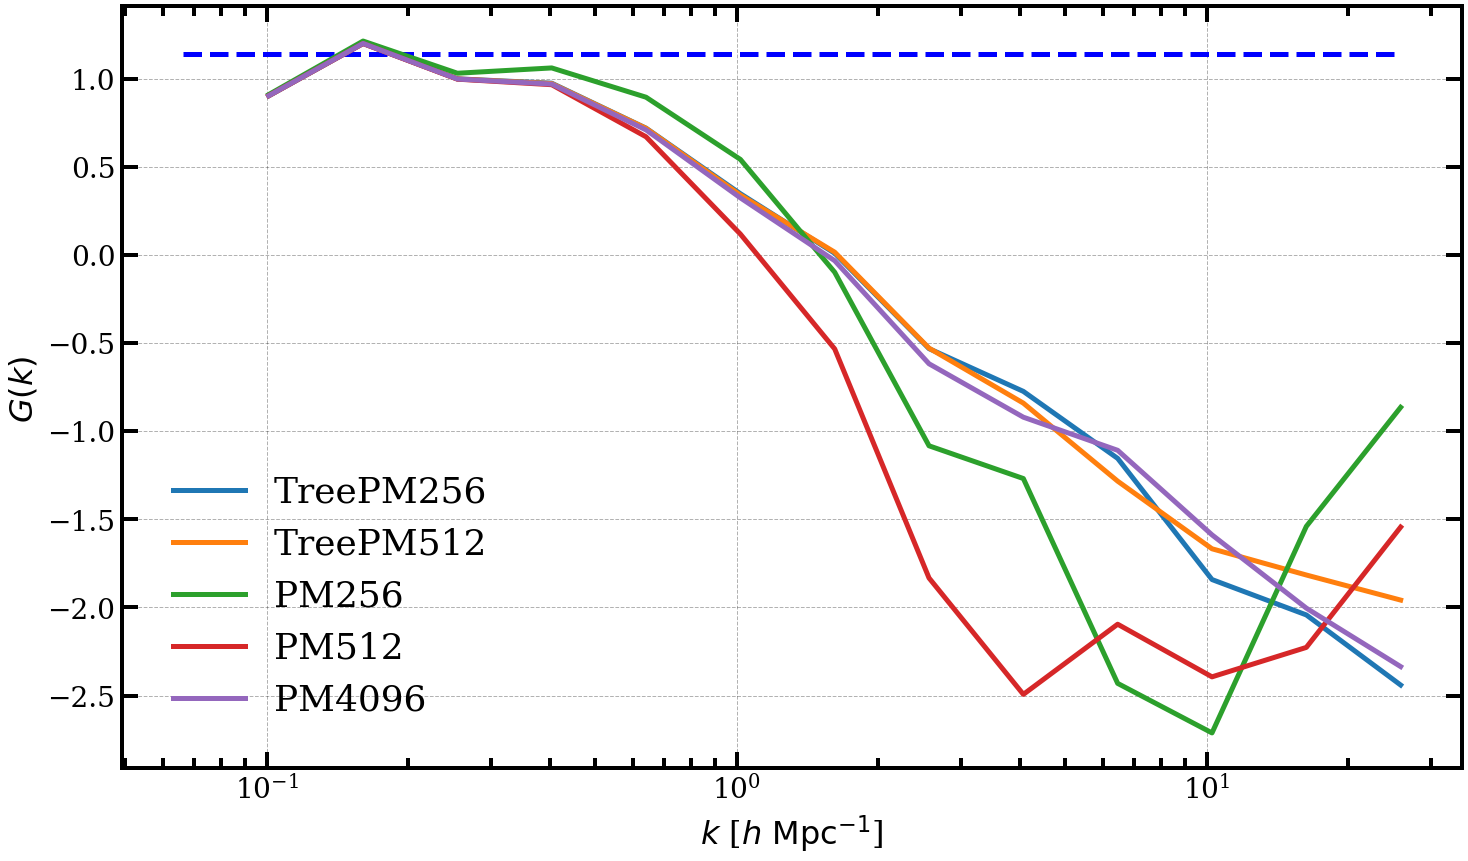

In [28]:
logGk = {}

for force in ['treepm256','treepm512','pm256','pm512','pm1024','pm2048','pm4096']:
    logGk[force] = np.array([logpow['k'], (logpow[force+'_mmp'] - logpow[force+'_ppm'])/(2*lambdaz*logpow[force+'_iso']*rel_D(0))])
    np.savetxt(f'/home/yinli/csit/analysis/response/planck2015/250/logGk_z0_{force}.dat', logGk[force])

logkbin_new = numpy.logspace(logmink+(logmaxk-logmink)/(2*(n_bin-1)), logmaxk+(logmaxk+logmink)/(2*(n_bin-1)), n_bin)

plt.plot(logkbin_new, logGk['treepm256'][1], label="TreePM256")
plt.plot(logkbin_new, logGk['treepm512'][1], label="TreePM512")
plt.plot(logkbin_new, logGk['pm256'][1], label="PM256")
plt.plot(logkbin_new, logGk['pm512'][1], label="PM512")
#plt.plot(logkbin_new, logGk['pm1024'][1], label="PM1024")
#plt.plot(logkbin_new, logGk['pm2048'][1], label="PM2048")
plt.plot(logkbin_new, logGk['pm4096'][1], label="PM4096")

#plt.plot(Gk['pm4096'][0], Gk['pm4096'][1], label="PM4096")
#plt.plot(Gk['pm256'][0], Gk['pm256'][1], label="PM256")
#plt.plot(Gk['pm1024'][0], Gk['pm1024'][1], label="PM1024")


plt.hlines([8./7.], Gk['treepm256'][0,0], Gk['treepm256'][0,-1], "blue", linestyles='dashed')     # hlines

plt.xscale('log')
#plt.legend(loc=0)
plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=18)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$G(k)$ ")
plt.savefig('/home/yinli/csit/analysis/response/planck2015/250/Gk_compare_dklog_treepm_pm.pdf')

In [35]:
import subprocess
subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'response.ipynb'])

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'python', 'response.ipynb'], returncode=0)